In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd


# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite",echo=False)

In [5]:
# Get the table names using `inspect()`.
inspector = inspect(engine)
tables = inspector.get_table_names()
print(tables)



['measurement', 'station']


In [6]:
# Get the column names for measurement using `inspect()`.
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [7]:
# Get the column names for station using `inspect()`.
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [8]:


# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)


In [9]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(most_recent_date[0],type(most_recent_date[0]))

2017-08-23 <class 'str'>


In [13]:
# Calculate a time difference of 12 months ago from most recent date in dataset '2017-08-23'
from datetime import datetime, timedelta

most_recent_date_str = most_recent_date[0]
most_recent_date_converted = datetime.strptime(most_recent_date_str, "%Y-%m-%d")

date_year_back = most_recent_date_converted - timedelta(days = 365)

ts = date_year_back.timestamp()
print(ts,date_year_back)

1471935600.0 2016-08-23 00:00:00


In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame. Explicitly set the column names
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data
sel =[Measurement.prcp,
      Measurement.station,
      Measurement.date,
     Measurement.tobs]

prcp_result = session.query(*sel).\
    filter(Measurement.date >= date_year_back).\
    order_by(Measurement.date.desc()).all()


cols = ['Precipitation','Station','Record_Date','Tobs']

measurement_df = pd.DataFrame(prcp_result,columns= cols)
measurement_df["Precipitation"].fillna(0.00, inplace = True)
measurement_df['Record_Date'] = measurement_df['Record_Date'].apply(lambda x:datetime.strptime(x, "%Y-%m-%d"))
measurement_df.sort_values("Record_Date")

measurement_df.head(30)


,Precipitation,Station,Record_Date,Tobs
0,0.00,USC00519397,2017-08-23,81.0
1,0.00,USC00514830,2017-08-23,82.0
2,0.08,USC00519523,2017-08-23,82.0
3,0.45,USC00516128,2017-08-23,76.0
4,0.00,USC00519397,2017-08-22,82.0
5,0.00,USC00519523,2017-08-22,82.0
6,0.50,USC00516128,2017-08-22,76.0
7,0.00,USC00519397,2017-08-21,81.0
8,0.02,USC00514830,2017-08-21,79.0
9,0.00,USC00519523,2017-08-21,82.0


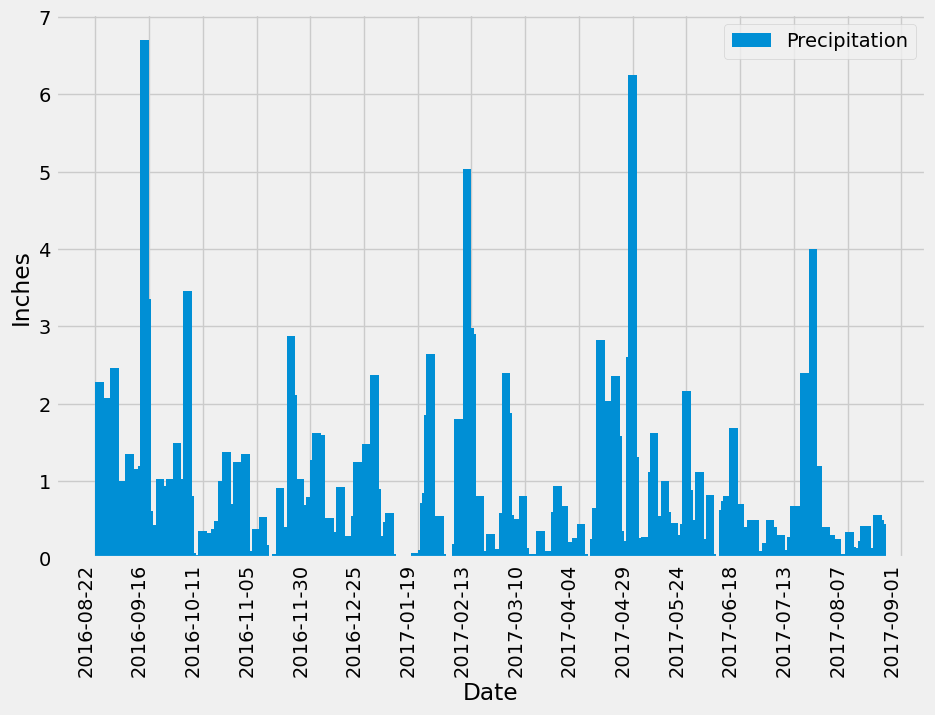

In [15]:
# Plot the Results in a Matplotlib bar chart

#using mdates.DayLocator()
#https://dataplotplus.com/change-frequency-date-x-axis-matplotlib-python/
import matplotlib.dates as mdates

plt.figure(figsize=(10,8))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
#plt.gca().xaxis.set_major_locator(mdates.DayLocator())

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=25))
plt.gcf().autofmt_xdate()

plt.bar(measurement_df['Record_Date'],measurement_df['Precipitation'],width = 4,label = 'Precipitation')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.legend()
plt.xticks(rotation=90)

plt.show()


Text(0, 0.5, 'Inches')

<Figure size 1000x800 with 0 Axes>

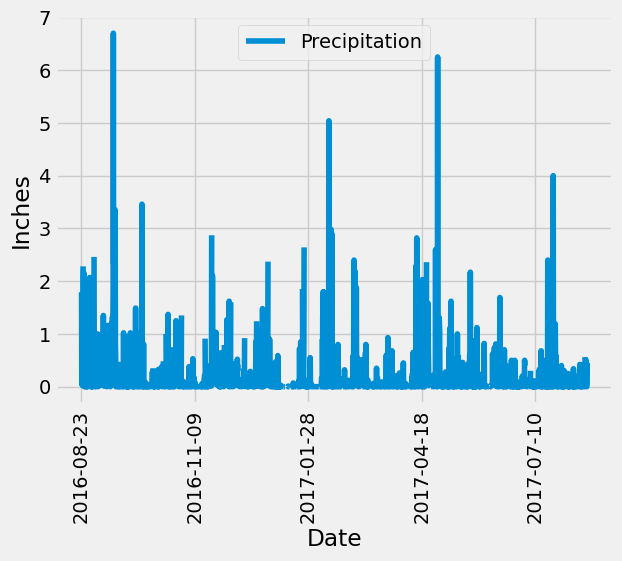

In [16]:
#alternate way
from datetime import date

dates_vals = date(2017, 8, 23) - timedelta(days=365)

sql_response = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= dates_vals).all()

prcp_df = pd.DataFrame(sql_response,columns=['Date', 'Precipitation'])
prcp_df = prcp_df.sort_values("Date")

plt.figure(figsize=(10,8))
prcp_df.plot(x='Date', y='Precipitation', rot=90)

plt.ylabel('Inches')


In [17]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_summary_df = pd.DataFrame(measurement_df['Precipitation'].describe())
precipitation_summary_df

,Precipitation
count,2223.000000
mean,0.159951
std,0.441220
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


# Exploratory Station Analysis

In [18]:
# Design a query to calculate the total number of stations in the dataset
sel =[Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation]

station_result = session.query(*sel).all()

cols = ['Station','Station_Name','Latitude','Longitude','Elevation']

station_df = pd.DataFrame(station_result,columns= cols)

total_number_stations = station_df['Station'].nunique()
print("Total number of Stations: ", total_number_stations) 


Total number of Stations:  9


In [19]:
station_df.head(30)

,Station,Station_Name,Latitude,Longitude,Elevation
0,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [20]:
# Getting Total number of stations using SQLALCHEMY
sel =[func.count(Station.id)]

station_result = session.query(*sel).all()
station_result[0]

(9,)

In [21]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

sel =[Measurement.station,
      func.count(Measurement.id)]

station_result = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()

print("Active stations: ") 
print(station_result)

most_active_station = station_result[0][0]

print("Most active station: ", most_active_station)



Active stations: 
[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]
Most active station:  USC00519281


In [22]:
measurement_df.head()

,Precipitation,Station,Record_Date,Tobs
0,0.00,USC00519397,2017-08-23,81.0
1,0.00,USC00514830,2017-08-23,82.0
2,0.08,USC00519523,2017-08-23,82.0
3,0.45,USC00516128,2017-08-23,76.0
4,0.00,USC00519397,2017-08-22,82.0


In [23]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

most_active_station_df = measurement_df[measurement_df['Station'] == most_active_station]

Temperature_summary = pd.DataFrame(most_active_station_df['Tobs'].describe())

#Filtering only the data I need from describe() output
Temperature_summary = Temperature_summary.loc[['min','mean','max']].T

Temperature_summary['Station'] = most_active_station

Temperature_summary = Temperature_summary.rename(columns={'min':'Min_Temperature',
                                                           'mean':'Avg_Temperature',
                                                           'max':'Max_Temperature'})

Temperature_summary

,Min_Temperature,Avg_Temperature,Max_Temperature,Station
Tobs,59.0,73.096866,83.0,USC00519281


In [24]:
most_active_station_df.head()

,Precipitation,Station,Record_Date,Tobs
20,0.06,USC00519281,2017-08-18,79.0
24,0.01,USC00519281,2017-08-17,76.0
28,0.12,USC00519281,2017-08-16,76.0
33,0.32,USC00519281,2017-08-15,77.0
38,0.00,USC00519281,2017-08-14,77.0


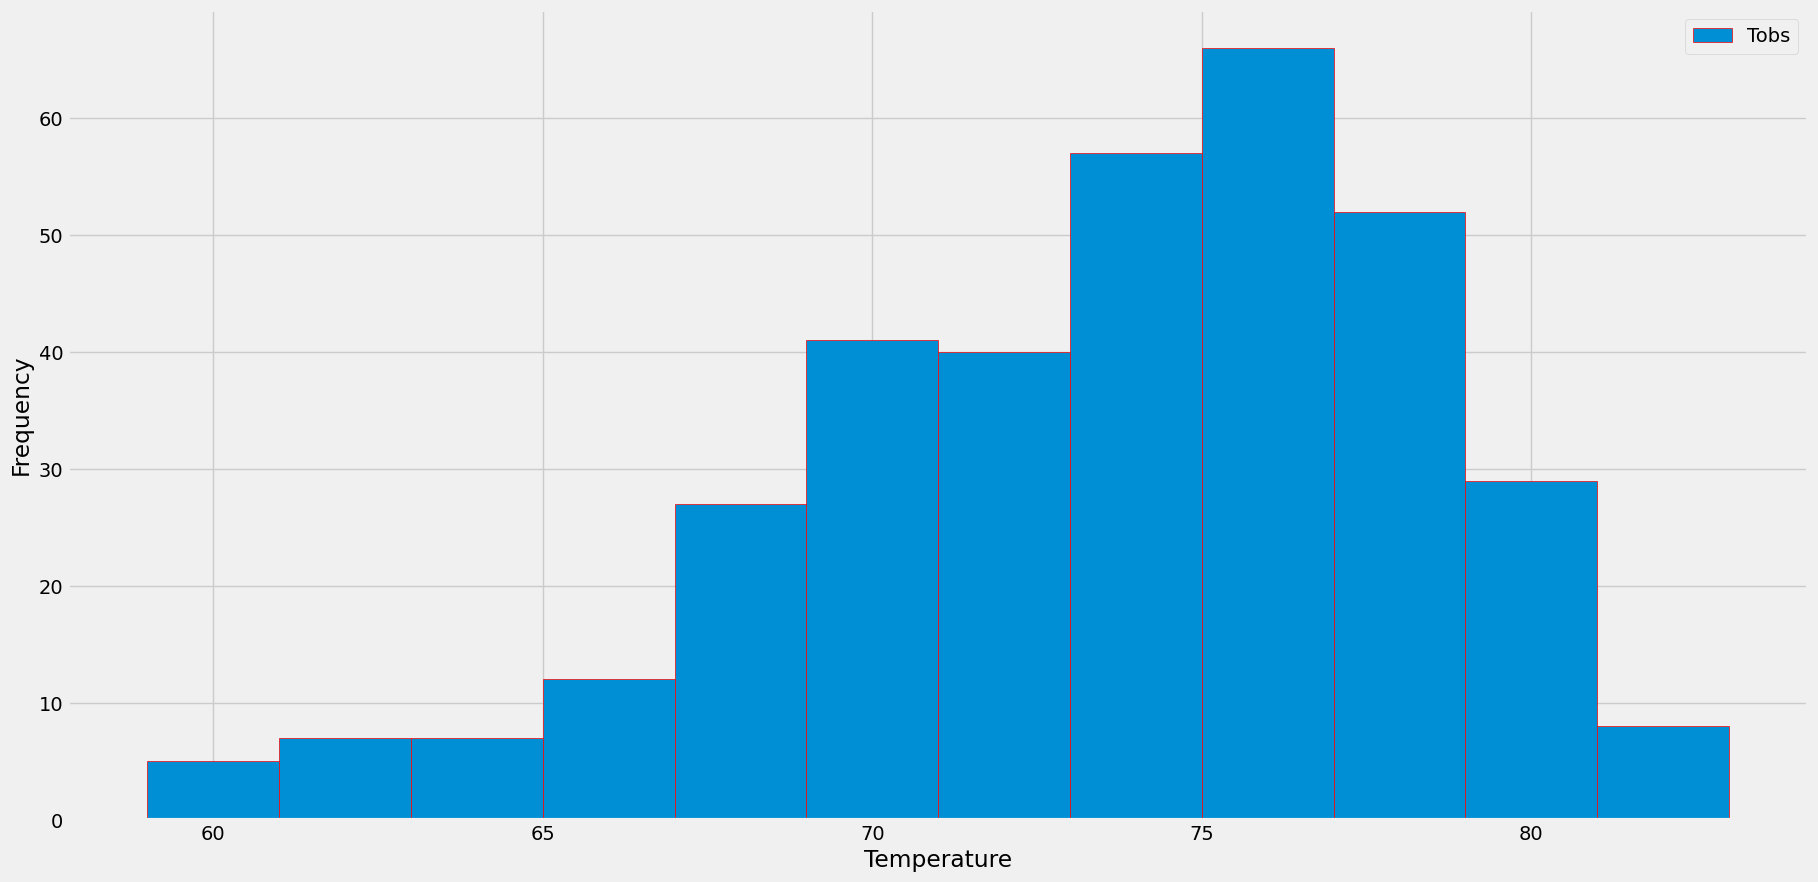

In [25]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

plt.figure(figsize=(20,10))
histogram = plt.hist(most_active_station_df['Tobs'], edgecolor="red", bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(['Tobs'])
plt.show()


# Close Session

In [26]:
# Close Session
session.close()